In [1]:
from collections import Counter
import pickle
import os
import yaml
import random
import numpy as np
import pandas as pd

from time import time
import matplotlib.pyplot as plt

from scipy.stats import bernoulli, gaussian_kde
from sklearn import decomposition


import matplotlib.pyplot as plt

os.chdir(os.path.expanduser("~/projects/embedding/src"))
from probe2vec.w2v import word2vec, Word2VecEmbedder
from probe2vec.dataset_reader import DatasetReader
from probe2vec.embedding_utils import build_index, most_similar, merge_counters, reshape_to_vector, SequenceParser
from probe2vec.theano_minibatcher import (
    TheanoMinibatcher, NoiseContrastiveTheanoMinibatcher
)

In [2]:
# get the model file params
%matplotlib inline

config_dir = os.path.expanduser('~/projects/embedding/src/config_yamls/atac_kmer_models/')
results_dir = os.path.expanduser('~/projects/embedding/results/GM12878_atac/distal_seq_kernel/k_6_s_1')
model_yaml = 'k_6_s_1_distal.yaml'
with open(os.path.join(config_dir, model_yaml)) as f:
    params = yaml.load(f)

In [3]:
# load the embedder
ChIP_data_dir = os.path.expanduser('~/projects/SeqDemote/data/ChIP/GM12878/chip_fasta_files')
os.chdir(os.path.expanduser("~/projects/embedding/src"))

## Set up the machinery for reading, parsing, and embedding sequences

In [4]:
my_sp = SequenceParser(**params)

# load the DatasetReader object from the save dir
reader = DatasetReader(files=[], directories=[], skip=[], noise_ratio=15, 
                      t=1e-5, num_processes=3, 
                      unigram_dictionary=None, 
                      min_frequency=0, kernel=[1, 2, 3, 
                      4, 5, 5, 4, 3, 2, 1], 
                      load_dictionary_dir=params['save_dir'], 
                      max_queue_size=0, 
                      macrobatch_size=20000, 
                      parser=my_sp, 
                      verbose=True, k=params['K'], 
                      stride=params['stride'])
    
# load the embedder, DatasetReader objects
batch_size = 1000
noise_ratio=15
num_embedding_dimensions=params['num_embedding_dimensions']
full_batch_size = batch_size * (1 + noise_ratio)

minibatcher = NoiseContrastiveTheanoMinibatcher(
    batch_size=batch_size,
    noise_ratio=noise_ratio,
    dtype="int32",
    num_dims=2
)

embedder = Word2VecEmbedder(input_var=minibatcher.get_batch(),
                            batch_size=full_batch_size,
                            vocabulary_size=reader.get_vocab_size(),
                            num_embedding_dimensions=num_embedding_dimensions)
embedder.load(os.path.join(params['save_dir'],''))
params['save_dir']

Loading dictionary from ../results/GM12878_atac/distal_seq_kernel/k_6_s_1...
pruning dictionary to eliminate tokens occuring less than 0 times.
dropped  0  tokens in pruning the unigram dictionary


'../results/GM12878_atac/distal_seq_kernel/k_6_s_1'

In [5]:
# Load a random set of probes from a randomly chosen factor, embed, and visualize the probes
def sample_from_factor(filename, percentage=0.5):
    tokenized_sentences = my_sp.parse(filename) 
    samples = bernoulli.rvs(percentage,size=len(tokenized_sentences)).astype('bool').tolist()
    return [s for s,i in zip(tokenized_sentences,samples) if i], [s for s,i in zip(tokenized_sentences,samples) if not i]
    

# Sample several factors from the ChIP data

Here is the recipe for orthogonal validation of an embedding model via ChIP data:
- choose a set of five factors
- sample sequences from the peaks
- sample sequences from the flanks
- transform sequences into embedding space to get the embedded features
- transform sequences via CountVectorizer -> RandomProjection to get the direct from sequence features
- push both through a pipeline for classification of peaks from flanks

In [13]:
# choose the factor
factors = os.listdir(ChIP_data_dir)
random.shuffle(factors)
my_factors = factors[0:5]

factor_dict = {}
for factor in my_factors:
    peaks_files = [f for f in os.listdir(os.path.join(ChIP_data_dir,factor)) if f.endswith("peaks.fa")]
    peak_file = os.path.join(ChIP_data_dir,factor,peaks_files[0])
    flank_files = [f for f in os.listdir(os.path.join(ChIP_data_dir,factor)) if f.endswith("flanks.fa")]
    flank_file = os.path.join(ChIP_data_dir,factor,flank_files[0])

    # sample peak, flank sequences
    percentage = 0.8
    training_peaks, validation_peaks = sample_from_factor(peak_file, percentage)
    training_flanks, validation_flanks = sample_from_factor(flank_file, percentage)
    
    factor_dict[factor] = [(training_peaks, validation_peaks),(training_flanks, validation_flanks)]

### Package up the data set

For each factor in the factor dict:

1. Embed the peaks, flanks into the embedding space
2. Form the peaks, flanks into a numpy array, and make the labels
3. Embed the peaks, flanks by random projection 

In [ ]:
training_embedded_factor_dict = {}

for f in factor_dict:
    (training_peaks, validation_peaks), (training_flanks, validation_flanks) = factor_dict[f]
    

    # Embed each of the k-mers from the sample sentences, and the other sentences
    embedded_peaks = []
    embedded_peaks_means = []
    for count, peak in enumerate(training_peaks):
        peak_token_ids = [reader.unigram_dictionary.get_id(token) for token in peak]
        embedded_tokens = [embedder.embed(t) for t in peak_token_ids]
        embedded_peaks.append(embedded_tokens)
        embedded_peaks_means.append(np.concatenate(embedded_tokens).mean(axis=0))

    training_peak_X = np.stack(embedded_peaks_means)

    embedded_flanks = []
    embedded_flanks_means = []
    for count, flank in enumerate(training_flanks):
        flank_token_ids = [reader.unigram_dictionary.get_id(token) for token in flank]
        embedded_tokens = [embedder.embed(t) for t in flank_token_ids]
        embedded_flanks.append(embedded_tokens)
        embedded_flanks_means.append(np.concatenate(embedded_tokens).mean(axis=0))

    training_flank_X = np.stack(embedded_flanks_means)

    training_peak_labels = np.ones((len(training_peaks),))
    training_flank_labels = np.zeros((len(training_flanks),))
    print("training peaks shape: ", training_peak_X.shape)
    print("training flanks shape:", training_flank_X.shape)

    X_train_embedded = np.concatenate((training_peak_X,training_flank_X))
    Y_train_labels = np.concatenate((training_peak_labels,training_flank_labels))

    training_embedded_factor_dict[f] = (X_train_embedded,Y_train_labels)
    print("Shape of the training data: ", X_train_embedded.shape)
    print("Shape of the training labels: ", Y_train_labels.shape)

Warning, unrecognized token: GGCGCN
Warning, unrecognized token: GCGCNN
Warning, unrecognized token: CGCNNN
Warning, unrecognized token: GCNNNN
Warning, unrecognized token: CNNNNN


In [9]:
validation_embedded_factor_dict = {}

for f in factor_dict:
    (training_peaks, validation_peaks), (training_flanks, validation_flanks) = factor_dict[f]

    embedded_peaks = []
    embedded_peaks_means = []
    for count, peak in enumerate(validation_peaks):
        peak_token_ids = [reader.unigram_dictionary.get_id(token) for token in peak]
        embedded_tokens = [embedder.embed(t) for t in peak_token_ids]
        embedded_peaks.append(embedded_tokens)
        embedded_peaks_means.append(np.concatenate(embedded_tokens).mean(axis=0))

    validation_peak_X = np.stack(embedded_peaks_means)

    embedded_flanks = []
    embedded_flanks_means = []
    for count, flank in enumerate(validation_flanks):
        flank_token_ids = [reader.unigram_dictionary.get_id(token) for token in flank]
        embedded_tokens = [embedder.embed(t) for t in flank_token_ids]
        embedded_flanks.append(embedded_tokens)
        embedded_flanks_means.append(np.concatenate(embedded_tokens).mean(axis=0))

    validation_flank_X = np.stack(embedded_flanks_means)

    validation_peak_labels = np.ones((len(validation_peaks),))
    validation_flank_labels = np.zeros((len(validation_flanks),))
    print("Validation peak shape: ", validation_peak_X.shape)
    print("Validation flank shape:", validation_flank_X.shape)

    X_validation_embedded = np.concatenate((validation_peak_X, validation_flank_X))
    Y_validation_labels = np.concatenate((validation_peak_labels, validation_flank_labels))

    print("Shape of the validation data: ", X_validation_embedded.shape)
    print("Shape of the validation labels: ", Y_validation_labels.shape)
    
    validation_embedded_factor_dict[f] = (X_validation_embedded, Y_validation_labels)

Warning, unrecognized token: GGCGCN
Warning, unrecognized token: GCGCNN
Warning, unrecognized token: CGCNNN
Warning, unrecognized token: GCNNNN
Warning, unrecognized token: CNNNNN
Validation peak shape:  (1632, 100)
Validation flank shape: (3127, 100)
Shape of the validation data:  (4759, 100)
Shape of the validation labels:  (4759,)
Warning, unrecognized token: NNNNNG
Warning, unrecognized token: NNNNGT
Warning, unrecognized token: NNNGTC
Warning, unrecognized token: NNGTCA
Warning, unrecognized token: NGTCAC
Warning, unrecognized token: GGCGCN
Warning, unrecognized token: GCGCNN
Warning, unrecognized token: CGCNNN
Warning, unrecognized token: GCNNNN
Warning, unrecognized token: CNNNNN
Validation peak shape:  (2111, 100)
Validation flank shape: (4114, 100)
Shape of the validation data:  (6225, 100)
Shape of the validation labels:  (6225,)
Validation peak shape:  (752, 100)
Validation flank shape: (1251, 100)
Shape of the validation data:  (2003, 100)
Shape of the validation labels:  (

### Now the Random Permutations baseline

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.random_projection import GaussianRandomProjection
from scipy.sparse import vstack

vectorizer = CountVectorizer(analyzer='word',lowercase=False)
gpr = GaussianRandomProjection(n_components=100)

training_projection_factor_dict = {}
validation_projection_factor_dict = {}

for f in factor_dict:
    
    (training_peaks, validation_peaks), (training_flanks, validation_flanks) = factor_dict[f]
    joint_corpus = [" ".join(p) for p in training_peaks]
    for l in [[" ".join(f) for f in training_flanks], [" ".join(p) for p in validation_peaks], [" ".join(p) for p in validation_flanks]]:
        joint_corpus.extend(l)
    vectorizer.fit(joint_corpus)

    train_peaks_counts = vectorizer.transform([" ".join(p) for p in training_peaks])
    train_flanks_counts = vectorizer.transform([" ".join(f) for f in training_flanks])
    valid_peaks_counts = vectorizer.transform([" ".join(p) for p in validation_peaks])
    valid_flanks_counts = vectorizer.transform([" ".join(p) for p in validation_flanks])
    
    gpr.fit(train_peaks_counts)

    train_peaks_vectorized = gpr.transform(train_peaks_counts)
    train_flanks_vectorized = gpr.transform(train_flanks_counts)
    valid_peaks_vectorized = gpr.transform(valid_peaks_counts)
    valid_flanks_vectorized = gpr.transform(valid_flanks_counts)

    print("Shape, type of train_peaks_vectorized: ", train_peaks_vectorized.shape, type(train_peaks_vectorized))
    print("Shape, type of train_flanks_vectorized: ", train_flanks_vectorized.shape, type(train_flanks_vectorized))

    X_train_hashed = vstack((train_peaks_vectorized, train_flanks_vectorized))
    X_valid_hashed = vstack((valid_peaks_vectorized, valid_flanks_vectorized))

    print("Shape of the RP k-mer training data: ", X_train_hashed.shape)
    print("Shape of the RP k-mer validation data: ", X_valid_hashed.shape)
    
    training_peak_labels = np.ones((len(training_peaks),))
    training_flank_labels = np.zeros((len(training_flanks),))
    validation_peak_labels = np.ones((len(validation_peaks),))
    validation_flank_labels = np.zeros((len(validation_flanks),))
    
    Y_train_labels = np.concatenate((training_peak_labels,training_flank_labels))
    Y_valid_labels = np.concatenate((validation_peak_labels, validation_flank_labels))
    
    training_projection_factor_dict[f] = (X_train_hashed,Y_train_labels)
    validation_projection_factor_dict[f] = (X_valid_hashed,Y_valid_labels)
    

Shape, type of train_peaks_vectorized:  (6267, 100) <class 'numpy.ndarray'>
Shape, type of train_flanks_vectorized:  (12295, 100) <class 'numpy.ndarray'>
Shape of the RP k-mer training data:  (18562, 100)
Shape of the RP k-mer validation data:  (4759, 100)
Shape, type of train_peaks_vectorized:  (8612, 100) <class 'numpy.ndarray'>
Shape, type of train_flanks_vectorized:  (16364, 100) <class 'numpy.ndarray'>
Shape of the RP k-mer training data:  (24976, 100)
Shape of the RP k-mer validation data:  (6225, 100)
Shape, type of train_peaks_vectorized:  (2957, 100) <class 'numpy.ndarray'>
Shape, type of train_flanks_vectorized:  (4929, 100) <class 'numpy.ndarray'>
Shape of the RP k-mer training data:  (7886, 100)
Shape of the RP k-mer validation data:  (2003, 100)
Shape, type of train_peaks_vectorized:  (3446, 100) <class 'numpy.ndarray'>
Shape, type of train_flanks_vectorized:  (6654, 100) <class 'numpy.ndarray'>
Shape of the RP k-mer training data:  (10100, 100)
Shape of the RP k-mer valid

### Train competing classifiers on each feature set, evaluate on validation set

In [11]:
from sklearn import metrics

def benchmark(clf, train_data, train_labels, valid_data, valid_labels, print_report=True, print_cm=True):
    
    clf.fit(train_data, train_labels)
    pred = clf.predict(valid_data)
    
    if hasattr(clf, 'decision_function'):
        pred_score = clf.decision_function(valid_data)
        
    elif hasattr(clf, 'predict_proba'):
        pred_score = clf.predict_proba(valid_data)[:, 1]
        
    aupr = metrics.average_precision_score(valid_labels, pred_score)
    auroc = metrics.roc_auc_score(valid_labels, pred_score)    
    score = metrics.accuracy_score(valid_labels, pred) 
    f_one = metrics.f1_score(valid_labels, pred)
    
    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

    if print_report:
        print("classification report:")
        print(metrics.classification_report(valid_labels, pred))

    if print_cm:
        print("confusion matrix:")
        print(metrics.confusion_matrix(valid_labels, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    
    return clf_descr, score, aupr, auroc, f_one
    



In [12]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn.feature_selection import SelectFromModel

embedded_results_dict, hashed_results_dict = {}, {}

for f in factor_dict:
    
    X_train_embedded, Y_train_labels = training_embedded_factor_dict[f]
    X_validation_embedded, Y_validation_labels =  validation_embedded_factor_dict[f]
    X_train_hashed, _ = training_projection_factor_dict[f]
    X_valid_hashed, _ = validation_projection_factor_dict[f]
    embedded_results, hashed_results = [], []
    
    for train_data, valid_data, results in [[X_train_embedded, X_validation_embedded, embedded_results],
                                            [X_train_hashed, X_valid_hashed, hashed_results]]:
        for clf, name in (
                (RidgeClassifier(tol=1e-2, solver="lsqr"), "Ridge Classifier"),
                (KNeighborsClassifier(n_neighbors=10), "kNN"),
                (RandomForestClassifier(n_estimators=100), "Random forest")):
            print('=' * 80)
            print(name)
            results.append(benchmark(clf, train_data, Y_train_labels, valid_data, Y_validation_labels))

        for penalty in ["l2", "l1"]:
            print('=' * 80)
            print("%s penalty" % penalty.upper())
            # Train Liblinear model
            results.append(benchmark(LinearSVC(penalty=penalty, dual=False,
                                               tol=1e-3),
                                     train_data, Y_train_labels, valid_data, Y_validation_labels))

            # Train SGD model
            results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                                   penalty=penalty),
                                    train_data, Y_train_labels, valid_data, Y_validation_labels))

        # Train SGD with Elastic Net penalty
        print('=' * 80)
        print("Elastic-Net penalty")
        results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                               penalty="elasticnet"),
                                train_data, Y_train_labels, valid_data, Y_validation_labels))

        # Train sparse Naive Bayes classifiers
        print('=' * 80)
        print("Naive Bayes")
        results.append(benchmark(BernoulliNB(alpha=.01),
                      train_data, Y_train_labels, valid_data, Y_validation_labels))

        print('=' * 80)
        print("LinearSVC with L1-based feature selection")
        # The smaller C, the stronger the regularization.
        # The more regularization, the more sparsity.
        results.append(benchmark(Pipeline([
          ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                          tol=1e-3))),
          ('classification', LinearSVC(penalty="l2"))]),
                      train_data, Y_train_labels, valid_data, Y_validation_labels))
        
    embedded_results_dict[f] = embedded_results
    hashed_results_dict[f] = hashed_results

Ridge Classifier
dimensionality: 100
density: 1.000000
classification report:
             precision    recall  f1-score   support

        0.0       0.76      0.88      0.81      3127
        1.0       0.66      0.47      0.55      1632

avg / total       0.73      0.74      0.72      4759

confusion matrix:
[[2739  388]
 [ 863  769]]

kNN
classification report:
             precision    recall  f1-score   support

        0.0       0.73      0.88      0.80      3127
        1.0       0.63      0.38      0.47      1632

avg / total       0.70      0.71      0.69      4759

confusion matrix:
[[2761  366]
 [1013  619]]

Random forest
classification report:
             precision    recall  f1-score   support

        0.0       0.73      0.90      0.81      3127
        1.0       0.67      0.37      0.47      1632

avg / total       0.71      0.72      0.69      4759

confusion matrix:
[[2827  300]
 [1032  600]]

L2 penalty
dimensionality: 100
density: 1.000000
classification report:
   

/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


dimensionality: 100
density: 1.000000
classification report:
             precision    recall  f1-score   support

        0.0       0.74      0.91      0.82      3127
        1.0       0.70      0.40      0.51      1632

avg / total       0.73      0.73      0.71      4759

confusion matrix:
[[2842  285]
 [ 982  650]]

L1 penalty
dimensionality: 100
density: 0.790000
classification report:
             precision    recall  f1-score   support

        0.0       0.78      0.87      0.82      3127
        1.0       0.68      0.53      0.60      1632

avg / total       0.75      0.75      0.74      4759

confusion matrix:
[[2719  408]
 [ 767  865]]



/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


dimensionality: 100
density: 0.690000
classification report:
             precision    recall  f1-score   support

        0.0       0.76      0.90      0.82      3127
        1.0       0.70      0.46      0.55      1632

avg / total       0.74      0.75      0.73      4759

confusion matrix:
[[2801  326]
 [ 880  752]]

Elastic-Net penalty


/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


dimensionality: 100
density: 0.940000
classification report:
             precision    recall  f1-score   support

        0.0       0.77      0.87      0.82      3127
        1.0       0.67      0.50      0.57      1632

avg / total       0.73      0.74      0.73      4759

confusion matrix:
[[2716  411]
 [ 814  818]]

Naive Bayes
dimensionality: 100
density: 1.000000
classification report:
             precision    recall  f1-score   support

        0.0       0.77      0.55      0.64      3127
        1.0       0.45      0.69      0.54      1632

avg / total       0.66      0.60      0.61      4759

confusion matrix:
[[1726 1401]
 [ 508 1124]]

LinearSVC with L1-based feature selection
classification report:
             precision    recall  f1-score   support

        0.0       0.78      0.87      0.82      3127
        1.0       0.68      0.52      0.59      1632

avg / total       0.74      0.75      0.74      4759

confusion matrix:
[[2725  402]
 [ 779  853]]

Ridge Classifier


/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:319: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "


dimensionality: 100
density: 1.000000
classification report:
             precision    recall  f1-score   support

        0.0       0.69      0.91      0.79      3127
        1.0       0.57      0.24      0.33      1632

avg / total       0.65      0.68      0.63      4759

confusion matrix:
[[2840  287]
 [1247  385]]

kNN
classification report:
             precision    recall  f1-score   support

        0.0       0.68      0.86      0.76      3127
        1.0       0.44      0.21      0.28      1632

avg / total       0.59      0.64      0.59      4759

confusion matrix:
[[2697  430]
 [1296  336]]

Random forest
classification report:
             precision    recall  f1-score   support

        0.0       0.66      0.98      0.79      3127
        1.0       0.52      0.05      0.08      1632

avg / total       0.61      0.66      0.55      4759

confusion matrix:
[[3057   70]
 [1557   75]]

L2 penalty
dimensionality: 100
density: 1.000000
classification report:
             precisi

/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


dimensionality: 100
density: 1.000000
classification report:
             precision    recall  f1-score   support

        0.0       0.69      0.76      0.72      3127
        1.0       0.43      0.36      0.39      1632

avg / total       0.60      0.62      0.61      4759

confusion matrix:
[[2361  766]
 [1048  584]]

L1 penalty
dimensionality: 100
density: 1.000000
classification report:
             precision    recall  f1-score   support

        0.0       0.69      0.91      0.79      3127
        1.0       0.57      0.24      0.34      1632

avg / total       0.65      0.68      0.63      4759

confusion matrix:
[[2832  295]
 [1243  389]]



/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


dimensionality: 100
density: 0.310000
classification report:
             precision    recall  f1-score   support

        0.0       0.70      0.80      0.75      3127
        1.0       0.46      0.33      0.38      1632

avg / total       0.62      0.64      0.62      4759

confusion matrix:
[[2514  613]
 [1101  531]]

Elastic-Net penalty


/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


dimensionality: 100
density: 0.430000
classification report:
             precision    recall  f1-score   support

        0.0       0.72      0.71      0.71      3127
        1.0       0.45      0.46      0.46      1632

avg / total       0.63      0.63      0.63      4759

confusion matrix:
[[2226  901]
 [ 881  751]]

Naive Bayes
dimensionality: 100
density: 1.000000
classification report:
             precision    recall  f1-score   support

        0.0       0.70      0.82      0.76      3127
        1.0       0.49      0.33      0.39      1632

avg / total       0.63      0.65      0.63      4759

confusion matrix:
[[2569  558]
 [1094  538]]

LinearSVC with L1-based feature selection
classification report:
             precision    recall  f1-score   support

        0.0       0.70      0.84      0.77      3127
        1.0       0.51      0.31      0.39      1632

avg / total       0.64      0.66      0.64      4759

confusion matrix:
[[2638  489]
 [1122  510]]

Ridge Classifier
d

/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


dimensionality: 100
density: 1.000000
classification report:
             precision    recall  f1-score   support

        0.0       0.71      0.93      0.80      4114
        1.0       0.65      0.27      0.38      2111

avg / total       0.69      0.70      0.66      6225

confusion matrix:
[[3813  301]
 [1550  561]]

L1 penalty
dimensionality: 100
density: 0.820000
classification report:
             precision    recall  f1-score   support

        0.0       0.73      0.87      0.80      4114
        1.0       0.61      0.38      0.47      2111

avg / total       0.69      0.71      0.69      6225

confusion matrix:
[[3585  529]
 [1299  812]]



/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


dimensionality: 100
density: 0.680000
classification report:
             precision    recall  f1-score   support

        0.0       0.71      0.92      0.80      4114
        1.0       0.64      0.28      0.39      2111

avg / total       0.69      0.70      0.66      6225

confusion matrix:
[[3784  330]
 [1520  591]]

Elastic-Net penalty


/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


dimensionality: 100
density: 0.970000
classification report:
             precision    recall  f1-score   support

        0.0       0.71      0.93      0.81      4114
        1.0       0.65      0.27      0.39      2111

avg / total       0.69      0.70      0.66      6225

confusion matrix:
[[3806  308]
 [1534  577]]

Naive Bayes
dimensionality: 100
density: 1.000000
classification report:
             precision    recall  f1-score   support

        0.0       0.78      0.54      0.64      4114
        1.0       0.44      0.69      0.54      2111

avg / total       0.66      0.59      0.60      6225

confusion matrix:
[[2222 1892]
 [ 645 1466]]

LinearSVC with L1-based feature selection
classification report:
             precision    recall  f1-score   support

        0.0       0.73      0.87      0.80      4114
        1.0       0.61      0.38      0.47      2111

avg / total       0.69      0.71      0.69      6225

confusion matrix:
[[3598  516]
 [1312  799]]

Ridge Classifier


/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:319: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "


dimensionality: 100
density: 1.000000
classification report:
             precision    recall  f1-score   support

        0.0       0.68      0.92      0.78      4114
        1.0       0.50      0.15      0.23      2111

avg / total       0.62      0.66      0.59      6225

confusion matrix:
[[3800  314]
 [1799  312]]

kNN
classification report:
             precision    recall  f1-score   support

        0.0       0.68      0.88      0.77      4114
        1.0       0.45      0.19      0.26      2111

avg / total       0.60      0.65      0.60      6225

confusion matrix:
[[3629  485]
 [1719  392]]

Random forest
classification report:
             precision    recall  f1-score   support

        0.0       0.67      0.98      0.79      4114
        1.0       0.49      0.05      0.08      2111

avg / total       0.61      0.66      0.55      6225

confusion matrix:
[[4012  102]
 [2013   98]]

L2 penalty
dimensionality: 100
density: 1.000000
classification report:
             precisi

/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


dimensionality: 100
density: 1.000000
classification report:
             precision    recall  f1-score   support

        0.0       0.68      0.84      0.75      4114
        1.0       0.43      0.23      0.30      2111

avg / total       0.59      0.64      0.60      6225

confusion matrix:
[[3476  638]
 [1634  477]]

L1 penalty
dimensionality: 100
density: 1.000000
classification report:
             precision    recall  f1-score   support

        0.0       0.68      0.92      0.78      4114
        1.0       0.50      0.15      0.23      2111

avg / total       0.62      0.66      0.60      6225

confusion matrix:
[[3789  325]
 [1792  319]]



/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


dimensionality: 100
density: 0.320000
classification report:
             precision    recall  f1-score   support

        0.0       0.71      0.70      0.71      4114
        1.0       0.44      0.45      0.44      2111

avg / total       0.62      0.62      0.62      6225

confusion matrix:
[[2893 1221]
 [1161  950]]

Elastic-Net penalty


/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


dimensionality: 100
density: 0.220000
classification report:
             precision    recall  f1-score   support

        0.0       0.68      0.88      0.77      4114
        1.0       0.44      0.18      0.26      2111

avg / total       0.60      0.64      0.59      6225

confusion matrix:
[[3633  481]
 [1731  380]]

Naive Bayes
dimensionality: 100
density: 1.000000
classification report:
             precision    recall  f1-score   support

        0.0       0.70      0.80      0.74      4114
        1.0       0.45      0.32      0.38      2111

avg / total       0.61      0.64      0.62      6225

confusion matrix:
[[3278  836]
 [1430  681]]

LinearSVC with L1-based feature selection
classification report:
             precision    recall  f1-score   support

        0.0       0.68      0.86      0.76      4114
        1.0       0.45      0.23      0.31      2111

avg / total       0.61      0.65      0.61      6225

confusion matrix:
[[3527  587]
 [1622  489]]

Ridge Classifier
d

/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


dimensionality: 100
density: 1.000000
classification report:
             precision    recall  f1-score   support

        0.0       0.78      0.81      0.80      1251
        1.0       0.67      0.63      0.65       752

avg / total       0.74      0.74      0.74      2003

confusion matrix:
[[1015  236]
 [ 280  472]]

L1 penalty
dimensionality: 100
density: 0.750000
classification report:
             precision    recall  f1-score   support

        0.0       0.77      0.84      0.80      1251
        1.0       0.69      0.59      0.64       752

avg / total       0.74      0.74      0.74      2003

confusion matrix:
[[1047  204]
 [ 307  445]]



/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


dimensionality: 100
density: 0.710000
classification report:
             precision    recall  f1-score   support

        0.0       0.74      0.88      0.81      1251
        1.0       0.72      0.49      0.58       752

avg / total       0.73      0.74      0.72      2003

confusion matrix:
[[1106  145]
 [ 384  368]]

Elastic-Net penalty


/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


dimensionality: 100
density: 0.930000
classification report:
             precision    recall  f1-score   support

        0.0       0.77      0.84      0.80      1251
        1.0       0.68      0.57      0.62       752

avg / total       0.74      0.74      0.73      2003

confusion matrix:
[[1052  199]
 [ 321  431]]

Naive Bayes
dimensionality: 100
density: 1.000000
classification report:
             precision    recall  f1-score   support

        0.0       0.83      0.52      0.64      1251
        1.0       0.50      0.82      0.62       752

avg / total       0.70      0.63      0.63      2003

confusion matrix:
[[647 604]
 [137 615]]

LinearSVC with L1-based feature selection
classification report:
             precision    recall  f1-score   support

        0.0       0.77      0.84      0.80      1251
        1.0       0.69      0.59      0.63       752

avg / total       0.74      0.74      0.74      2003

confusion matrix:
[[1048  203]
 [ 310  442]]

Ridge Classifier


/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:319: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "


dimensionality: 100
density: 1.000000
classification report:
             precision    recall  f1-score   support

        0.0       0.71      0.85      0.77      1251
        1.0       0.62      0.41      0.50       752

avg / total       0.68      0.69      0.67      2003

confusion matrix:
[[1065  186]
 [ 443  309]]

kNN
classification report:
             precision    recall  f1-score   support

        0.0       0.70      0.83      0.76      1251
        1.0       0.59      0.40      0.48       752

avg / total       0.66      0.67      0.65      2003

confusion matrix:
[[1039  212]
 [ 451  301]]

Random forest
classification report:
             precision    recall  f1-score   support

        0.0       0.66      0.92      0.77      1251
        1.0       0.62      0.23      0.33       752

avg / total       0.65      0.66      0.60      2003

confusion matrix:
[[1146  105]
 [ 582  170]]

L2 penalty
dimensionality: 100
density: 1.000000
classification report:
             precisi

/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


dimensionality: 100
density: 1.000000
classification report:
             precision    recall  f1-score   support

        0.0       0.66      0.71      0.68      1251
        1.0       0.45      0.40      0.42       752

avg / total       0.58      0.59      0.59      2003

confusion matrix:
[[885 366]
 [452 300]]

L1 penalty
dimensionality: 100
density: 1.000000
classification report:
             precision    recall  f1-score   support

        0.0       0.71      0.85      0.77      1251
        1.0       0.62      0.41      0.50       752

avg / total       0.68      0.69      0.67      2003

confusion matrix:
[[1063  188]
 [ 441  311]]



/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


dimensionality: 100
density: 0.250000
classification report:
             precision    recall  f1-score   support

        0.0       0.73      0.73      0.73      1251
        1.0       0.55      0.54      0.55       752

avg / total       0.66      0.66      0.66      2003

confusion matrix:
[[916 335]
 [344 408]]

Elastic-Net penalty


/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


dimensionality: 100
density: 0.360000
classification report:
             precision    recall  f1-score   support

        0.0       0.71      0.64      0.67      1251
        1.0       0.48      0.56      0.52       752

avg / total       0.62      0.61      0.61      2003

confusion matrix:
[[795 456]
 [330 422]]

Naive Bayes
dimensionality: 100
density: 1.000000
classification report:
             precision    recall  f1-score   support

        0.0       0.72      0.75      0.74      1251
        1.0       0.56      0.52      0.54       752

avg / total       0.66      0.67      0.66      2003

confusion matrix:
[[942 309]
 [360 392]]

LinearSVC with L1-based feature selection
classification report:
             precision    recall  f1-score   support

        0.0       0.70      0.72      0.71      1251
        1.0       0.51      0.49      0.50       752

avg / total       0.63      0.63      0.63      2003

confusion matrix:
[[900 351]
 [383 369]]

Ridge Classifier
dimensionalit

/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


dimensionality: 100
density: 1.000000
classification report:
             precision    recall  f1-score   support

        0.0       0.78      0.84      0.81      1620
        1.0       0.67      0.59      0.63       919

avg / total       0.74      0.75      0.74      2539

confusion matrix:
[[1353  267]
 [ 377  542]]

L1 penalty
dimensionality: 100
density: 0.820000
classification report:
             precision    recall  f1-score   support

        0.0       0.78      0.87      0.82      1620
        1.0       0.70      0.56      0.63       919

avg / total       0.75      0.76      0.75      2539

confusion matrix:
[[1403  217]
 [ 401  518]]



/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


dimensionality: 100
density: 0.700000
classification report:
             precision    recall  f1-score   support

        0.0       0.76      0.88      0.82      1620
        1.0       0.71      0.51      0.60       919

avg / total       0.74      0.75      0.74      2539

confusion matrix:
[[1427  193]
 [ 446  473]]

Elastic-Net penalty


/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


dimensionality: 100
density: 0.990000
classification report:
             precision    recall  f1-score   support

        0.0       0.77      0.88      0.82      1620
        1.0       0.71      0.53      0.61       919

avg / total       0.75      0.75      0.74      2539

confusion matrix:
[[1418  202]
 [ 431  488]]

Naive Bayes
dimensionality: 100
density: 1.000000
classification report:
             precision    recall  f1-score   support

        0.0       0.73      0.64      0.68      1620
        1.0       0.48      0.59      0.53       919

avg / total       0.64      0.62      0.63      2539

confusion matrix:
[[1034  586]
 [ 374  545]]

LinearSVC with L1-based feature selection
classification report:
             precision    recall  f1-score   support

        0.0       0.77      0.87      0.82      1620
        1.0       0.71      0.55      0.62       919

avg / total       0.75      0.76      0.75      2539

confusion matrix:
[[1407  213]
 [ 409  510]]

Ridge Classifier


/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:319: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "


dimensionality: 100
density: 1.000000
classification report:
             precision    recall  f1-score   support

        0.0       0.67      0.90      0.77      1620
        1.0       0.54      0.22      0.31       919

avg / total       0.62      0.65      0.60      2539

confusion matrix:
[[1451  169]
 [ 717  202]]

kNN
classification report:
             precision    recall  f1-score   support

        0.0       0.66      0.90      0.76      1620
        1.0       0.49      0.17      0.25       919

avg / total       0.60      0.64      0.58      2539

confusion matrix:
[[1461  159]
 [ 765  154]]

Random forest
classification report:
             precision    recall  f1-score   support

        0.0       0.64      0.98      0.77      1620
        1.0       0.37      0.02      0.04       919

avg / total       0.54      0.63      0.51      2539

confusion matrix:
[[1586   34]
 [ 899   20]]

L2 penalty
dimensionality: 100
density: 1.000000
classification report:
             precisi

/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


dimensionality: 100
density: 1.000000
classification report:
             precision    recall  f1-score   support

        0.0       0.68      0.74      0.71      1620
        1.0       0.46      0.38      0.42       919

avg / total       0.60      0.61      0.60      2539

confusion matrix:
[[1205  415]
 [ 569  350]]

L1 penalty
dimensionality: 100
density: 1.000000
classification report:
             precision    recall  f1-score   support

        0.0       0.67      0.89      0.76      1620
        1.0       0.54      0.24      0.33       919

avg / total       0.63      0.65      0.61      2539

confusion matrix:
[[1436  184]
 [ 699  220]]



/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


dimensionality: 100
density: 0.340000
classification report:
             precision    recall  f1-score   support

        0.0       0.67      0.85      0.74      1620
        1.0       0.48      0.25      0.33       919

avg / total       0.60      0.63      0.59      2539

confusion matrix:
[[1371  249]
 [ 690  229]]

Elastic-Net penalty


/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


dimensionality: 100
density: 0.380000
classification report:
             precision    recall  f1-score   support

        0.0       0.67      0.68      0.68      1620
        1.0       0.42      0.41      0.42       919

avg / total       0.58      0.58      0.58      2539

confusion matrix:
[[1103  517]
 [ 538  381]]

Naive Bayes
dimensionality: 100
density: 1.000000
classification report:
             precision    recall  f1-score   support

        0.0       0.66      0.87      0.75      1620
        1.0       0.47      0.20      0.28       919

avg / total       0.59      0.63      0.58      2539

confusion matrix:
[[1406  214]
 [ 731  188]]

LinearSVC with L1-based feature selection
classification report:
             precision    recall  f1-score   support

        0.0       0.69      0.77      0.73      1620
        1.0       0.49      0.38      0.43       919

avg / total       0.61      0.63      0.62      2539

confusion matrix:
[[1253  367]
 [ 571  348]]

Ridge Classifier
d

/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/zamparol/anaconda36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ValueError: Expected n_neighbors <= n_samples,  but n_samples = 6, n_neighbors = 10

### Pack results into a df for plotting:
Results lists consist of: score, aupr, auroc, f_one
Need to tidy up data, get a df with cols identifying:
- classifier
- feature set
- measure

In [47]:
import pandas as pd

def assemble_df(results_list, factor, features):
    ''' turn results list into dict for df transformation '''
    
    entries = len(results_list)
    pd_dict = {'Features': [features for f in range(entries)], 'Classifier': [], 'Accuracy': [], 'AUROC': [], 'AUPR': [], 'F1': []}
    for record in results_list:
        name, acc, aupr, auroc, f_one = record
        pd_dict['Classifier'].append(name)
        pd_dict['Accuracy'].append(acc)
        pd_dict['AUPR'].append(aupr)
        pd_dict['AUROC'].append(auroc)
        pd_dict['F1'].append(f_one)
        
    return pd.DataFrame.from_dict(pd_dict)

In [55]:
# embedded_results, hashed_results
embedded_features_df = assemble_df(embedded_results, factor, "Embedding features")
hashed_features_df = assemble_df(hashed_results, factor, "Hashed features")

# concat dfs
all_features_df = pd.concat([embedded_features_df, hashed_features_df])

# melt into tidy format
tidy_df = pd.melt(all_features_df, id_vars=['Classifier', 'Features'], value_vars=['AUPR','AUROC','Accuracy','F1'], var_name='Metric', value_name='Value')

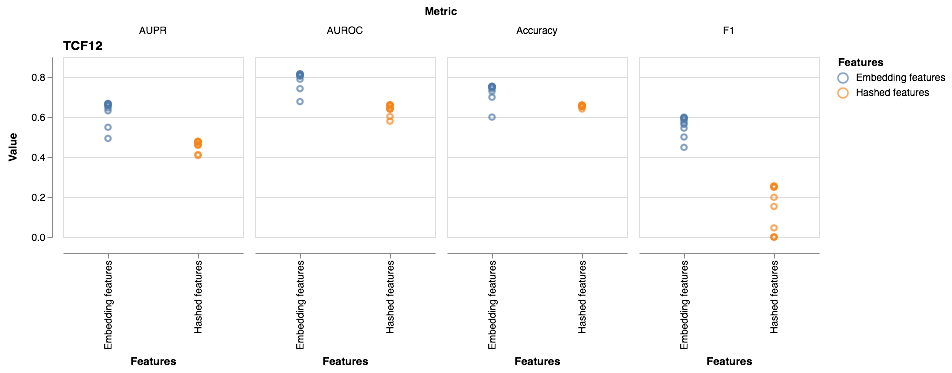

In [64]:
import altair as alt

title = factor

alt.Chart(tidy_df).mark_point().encode(
    x='Features:N',
    y='Value:Q',
    color='Features:N',
    column='Metric:N'
).properties(
    width=180,
    height=180,
    title=title
)